In [17]:
import pandas as pd
import numpy as np

In [18]:
# Cargar el archivo Excel
df = pd.read_excel("/content/Retail_Invoices.xlsx")

# Mostrar las primeras filas
df.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [19]:
from calidadf import calidad_datos # se usará la funcion calidadf para aplicar analisis de calidad de los datos, esta funcion estará disponible en la carpeta compartida

In [20]:
df_calidad = calidad_datos(df)  # Obtener análisis de calidad
print(df_calidad)  # Ver el resultado

                       tipo  nan  porcentaje_nan  ceros  porcentaje_ceros  \
CustomerID            int64    0             0.0      0          0.000000   
InvoiceDate  datetime64[ns]    0             0.0      0          0.000000   
Quantity              int64    0             0.0      0          0.000000   
StockCode             int64    0             0.0      0          0.000000   
price_total         float64    0             0.0      4          0.018026   
InvoiceNo            object    0             0.0      0          0.000000   

             valores_unicos  porcentaje_unicos                 moda  \
CustomerID             4372          19.702569              14911.0   
InvoiceDate             305           1.374493  2011-10-06 00:00:00   
Quantity               1594           7.183416                 -1.0   
StockCode               199           0.896800                  1.0   
price_total           16534          74.511041                -4.95   
InvoiceNo             22190       

/content/calidadf.py:47: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  info_calidad['moda'] = datos.mode().iloc[0]  # Primera moda


de acuerdo al resumen, no se observan valores nulos, ceros, el numero del la factura es un objeto por lo que deberiamos de cambiarlo a valor numerico para poder trabajar con el, otro valor que deberiamos de revisar es el aparecen negativos en Qantity y StockCode y price_total

In [16]:
df.describe()

,InvoiceDate,CustomerID,Quantity,price_total,StockCode
count,18532,18532.000000,18532.000000,18532.000000,18532.000000
mean,2011-07-01 03:39:44.718324736,15266.378211,278.899363,480.865956,21.471886
min,2010-12-01 00:00:00,12346.000000,1.000000,0.380000,1.000000
25%,2011-03-30 00:00:00,13776.250000,74.000000,158.037500,6.000000
50%,2011-07-12 00:00:00,15178.500000,155.000000,303.040000,15.000000
75%,2011-10-12 00:00:00,16779.000000,291.000000,471.840000,28.000000
max,2011-12-09 00:00:00,18287.000000,80995.000000,168469.600000,542.000000
std,NaN,1734.116296,972.734580,1678.195579,24.920241


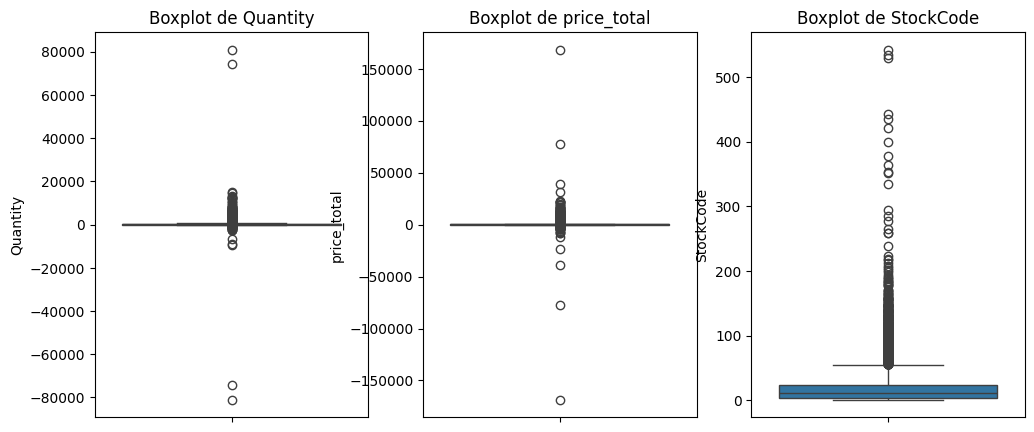

In [21]:
# para observar valores extremos

import seaborn as sns
import matplotlib.pyplot as plt

# Definir columnas a analizar
cols = ["Quantity", "price_total", "StockCode"]

# Crear boxplots
plt.figure(figsize=(12, 5))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.show()

In [24]:
# vamos a reemplazar los valores negativos porque claramente van a afectar el análisis
df = df[df["Quantity"] > 0]
df = df[df["price_total"] > 0]

#verificamos que no existan valores negativos

# Verificar que no haya valores negativos
print("Valores negativos restantes:")
print(df[df[["Quantity", "price_total"]].lt(0).any(axis=1)])

Valores negativos restantes:
Empty DataFrame
Columns: [InvoiceNo, InvoiceDate, CustomerID, Quantity, price_total, StockCode]
Index: []


el df resultante esta vacio, lo que indica que ya eliminamos los valores negativos.

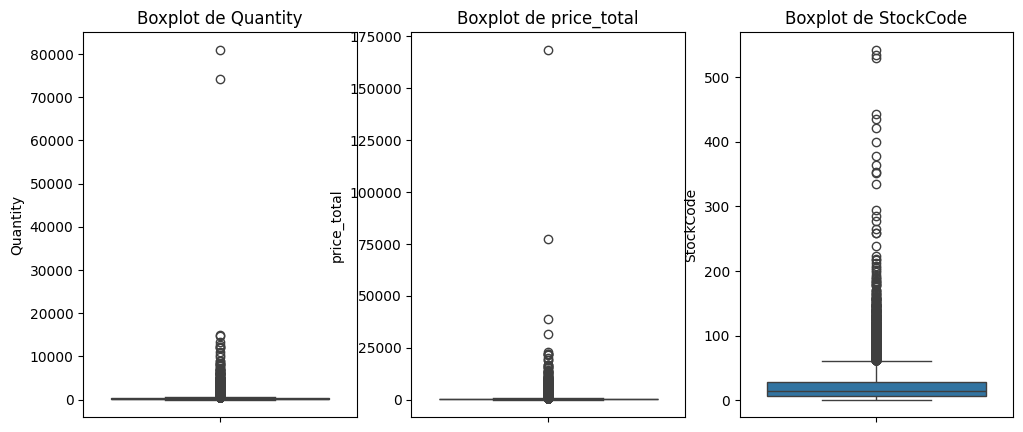

In [25]:
# Definir columnas a analizar
cols = ["Quantity", "price_total", "StockCode"]

# Crear boxplots
plt.figure(figsize=(12, 5))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.show()

vemos ahora la existencia de outliers importantes en quantioty y price_total, vamos a tratarlos para seguirr con el analisis de datos

In [26]:
# Función para eliminar outliers con IQR
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

# Aplicar eliminación de outliers
df_clean = eliminar_outliers(df, "Quantity")
df_clean = eliminar_outliers(df_clean, "price_total")
df_clean = eliminar_outliers(df_clean, "StockCode")

# Mostrar cantidad de filas después de limpieza
print(f"Filas antes de limpieza: {len(df)}")
print(f"Filas después de limpieza: {len(df_clean)}")

Filas antes de limpieza: 18532
Filas después de limpieza: 15450


En este caso, eliminamos casi el 16% de los datos (≈ 3000 de 18532), lo cual no es menor.
Si los datos eliminados representan casos reales y valiosos, podríamos estar perdiendo información clave sobre clientes que gastan mucho o compran en grandes cantidades.
Si los datos eliminados son errores o registros raros, eliminarlos puede mejorar la calidad del modelo de segmentación.

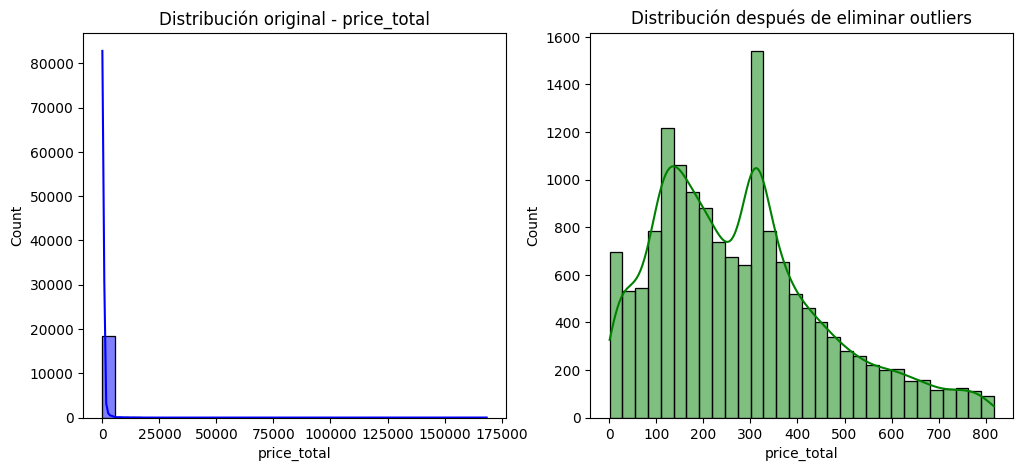

In [28]:
# Antes de continuar veamos si esos outliers representan clientes importantes o solo ruido en los datos.
import matplotlib.pyplot as plt

# Comparar distribuciones antes y después
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["price_total"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribución original - price_total")

sns.histplot(df_clean["price_total"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribución después de eliminar outliers")

plt.show()

vemos que el resultado de eliminar los outliers nos proporciona una mejor distribucion de datos por lo tanto consideramos la eliminacion de estos

la matriz de correlacion nos indica que existe correlacion netre el precio total y la cantidad

# Analsis Exploratorio de Datos

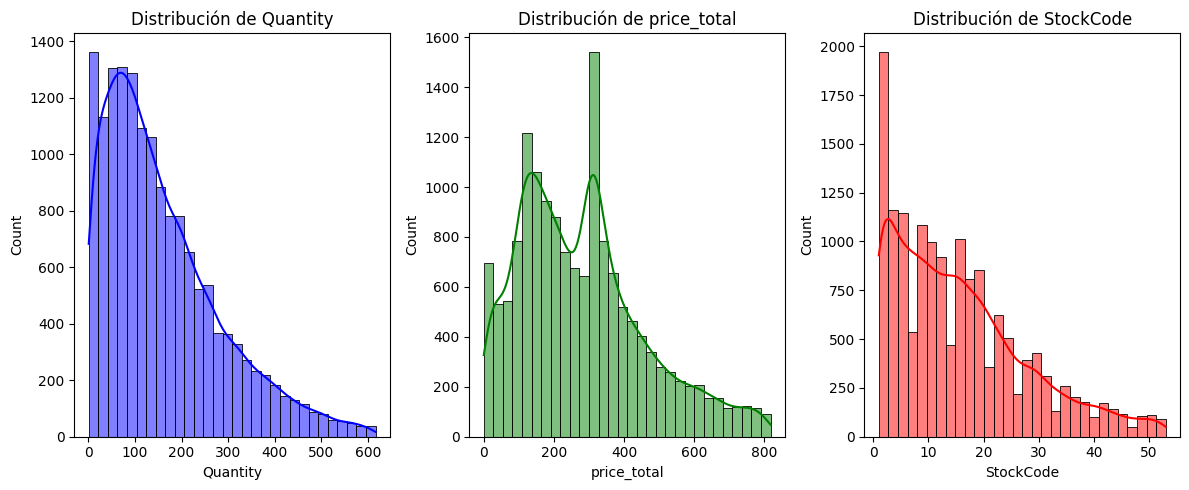

In [30]:
# Visualización de distribuciones
plt.figure(figsize=(12, 5))

# Quantity
plt.subplot(1, 3, 1)
sns.histplot(df_clean["Quantity"], bins=30, kde=True, color="blue")
plt.title("Distribución de Quantity")

# price_total
plt.subplot(1, 3, 2)
sns.histplot(df_clean["price_total"], bins=30, kde=True, color="green")
plt.title("Distribución de price_total")

# StockCode
plt.subplot(1, 3, 3)
sns.histplot(df_clean["StockCode"], bins=30, kde=True, color="red")
plt.title("Distribución de StockCode")

plt.tight_layout()
plt.show()

Correlacion entre variables numericas

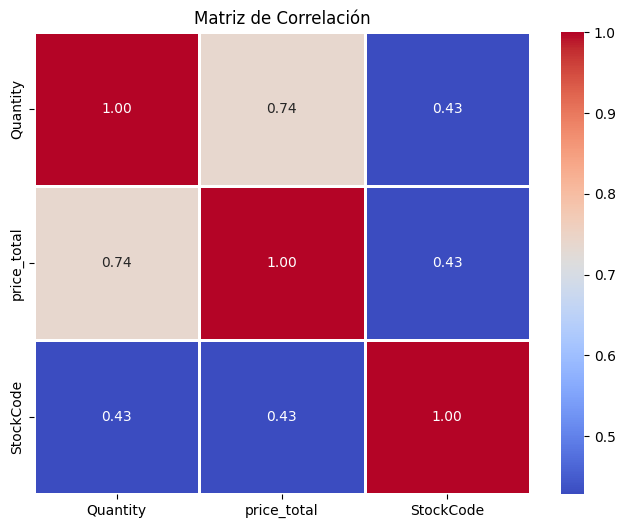

In [31]:
# Correlación entre las variables numéricas
correlation_matrix = df_clean[["Quantity", "price_total", "StockCode"]].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Matriz de Correlación")
plt.show()

se observa correlacion entre price y quantity

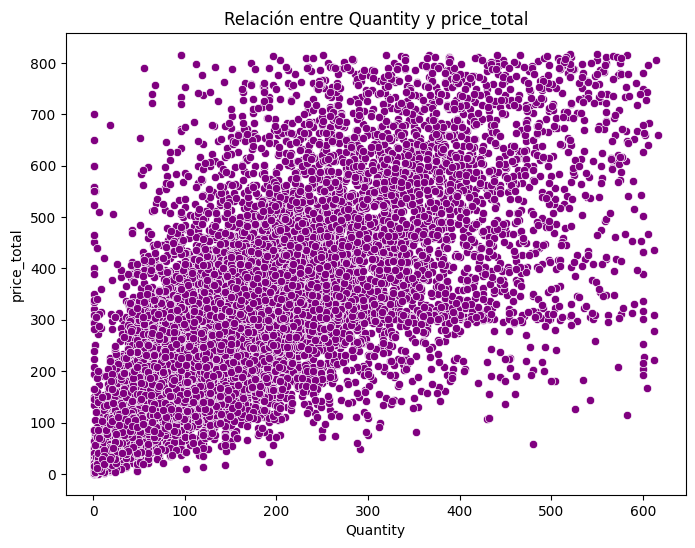

In [33]:
# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clean["Quantity"], y=df_clean["price_total"], color="purple")
plt.title("Relación entre Quantity y price_total")
plt.xlabel("Quantity")
plt.ylabel("price_total")
plt.show()

# Generacion de variables RFM

In [36]:
# Generación de las variables RFM
rfm = df_clean.groupby("CustomerID").agg(
    Recencia=("InvoiceDate", lambda x: (fecha_actual - x.max()).days),  # Días desde la última compra
    Frecuencia=("InvoiceNo", "nunique"),  # Número de compras (boletas)
    Monto=("price_total", "sum")  # Suma total gastado
).reset_index()

# Verificar las primeras filas
print(rfm.head())

   CustomerID  Recencia  Frecuencia    Monto
0       12347         2           6  3015.68
1       12348        75           3   904.44
2       12350       310           1   334.40
3       12352        36           7  1665.74
4       12353       204           1    89.00


Ahora vamos a normalizar para asegurarnos de que ninguna variable tenga más peso debido a su escala. Esto es especialmente importante para variables como Monto, que tiene una escala mucho mayor que Recencia o Frecuencia.

In [37]:
from sklearn.preprocessing import StandardScaler

# Normalizar las variables RFM
scaler = StandardScaler()
rfm_normalized = rfm[["Recencia", "Frecuencia", "Monto"]]
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_normalized), columns=["Recencia", "Frecuencia", "Monto"])

# Verificación de las variables normalizadas
print(rfm_normalized.head())

   Recencia  Frecuencia     Monto
0 -0.942315    0.345775  1.041470
1 -0.230789   -0.131409 -0.089414
2  2.059742   -0.449531 -0.394756
3 -0.610919    0.504836  0.318375
4  1.026567   -0.449531 -0.526204


In [38]:
from sklearn.cluster import KMeans

# Aplicar K-means
kmeans = KMeans(n_clusters=4, random_state=42)  # Ejemplo con 4 clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Ver los primeros resultados con las etiquetas de cluster
print(rfm.head())

   CustomerID  Recencia  Frecuencia    Monto  Cluster
0       12347         2           6  3015.68        1
1       12348        75           3   904.44        1
2       12350       310           1   334.40        3
3       12352        36           7  1665.74        1
4       12353       204           1    89.00        3


In [39]:
# Análisis por cluster
segmentos = rfm.groupby('Cluster').agg(
    Recencia_mean=("Recencia", "mean"),
    Frecuencia_mean=("Frecuencia", "mean"),
    Monto_mean=("Monto", "mean")
).reset_index()

# Ver los resultados por segmento
print(segmentos)

   Cluster  Recencia_mean  Frecuencia_mean    Monto_mean
0        0      17.337580        15.334395   4741.698408
1        1      45.956672         3.106595    839.622068
2        2       5.900000        82.100000  22943.924000
3        3     246.929476         1.547920    378.041076


# Aplicando 2 algoritmos de clustering

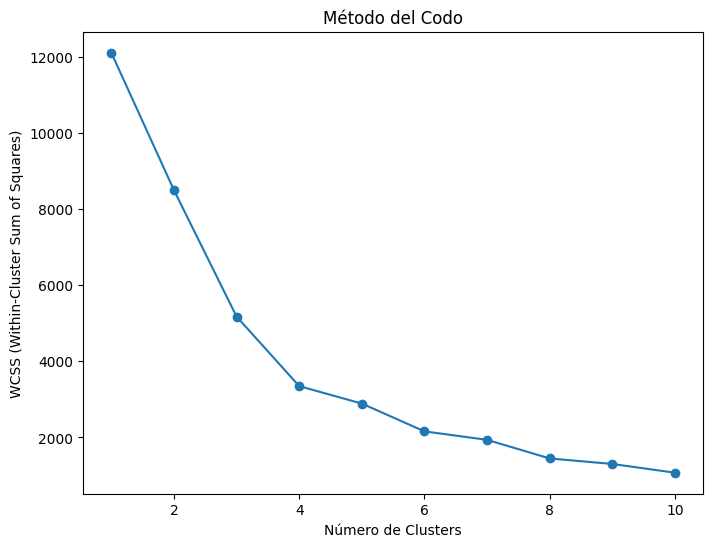

In [40]:
# Determinamos el número óptimo de clusters usando el método del codo
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):  # Probaremos entre 1 y 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

de acuerdo al modelo, podriamos definir como numero de clusters =4

In [41]:
# Aplicar K-means con el número óptimo de clusters  (4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_normalized)

# Ver los primeros resultados con las etiquetas de cluster
print(rfm.head())

   CustomerID  Recencia  Frecuencia    Monto  Cluster  Cluster_KMeans
0       12347         2           6  3015.68        1               1
1       12348        75           3   904.44        1               1
2       12350       310           1   334.40        3               3
3       12352        36           7  1665.74        1               1
4       12353       204           1    89.00        3               3


DBSCAN

In [42]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustar eps y min_samples según sea necesario
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_normalized)

# Ver los primeros resultados con las etiquetas de cluster
print(rfm.head())

   CustomerID  Recencia  Frecuencia    Monto  Cluster  Cluster_KMeans  \
0       12347         2           6  3015.68        1               1   
1       12348        75           3   904.44        1               1   
2       12350       310           1   334.40        3               3   
3       12352        36           7  1665.74        1               1   
4       12353       204           1    89.00        3               3   

   Cluster_DBSCAN  
0               0  
1               0  
2               0  
3               0  
4               0  


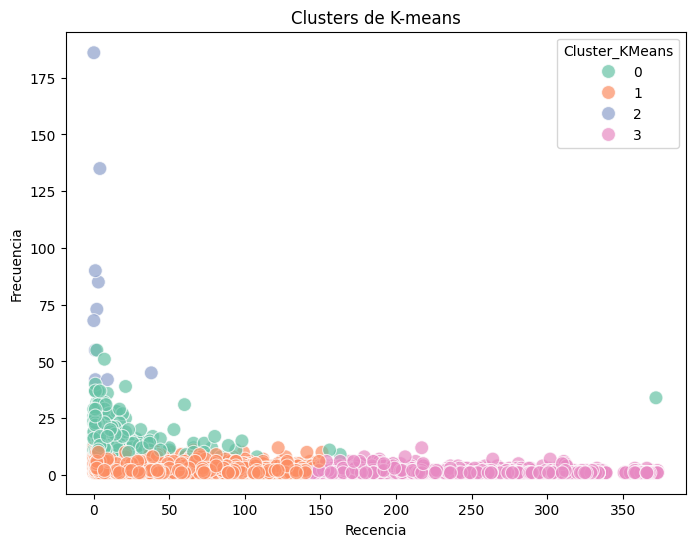

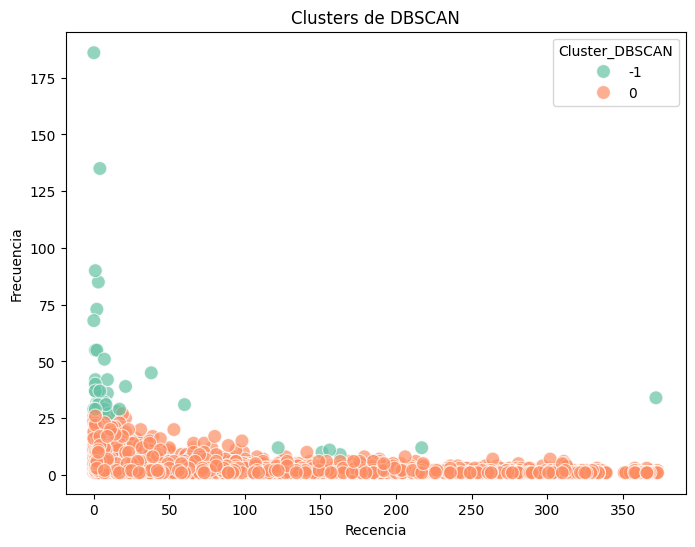

In [43]:
# Visualización de K-means Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm["Recencia"], y=rfm["Frecuencia"], hue=rfm["Cluster_KMeans"], palette="Set2", s=100, alpha=0.7)
plt.title("Clusters de K-means")
plt.xlabel("Recencia")
plt.ylabel("Frecuencia")
plt.show()

# Visualización de DBSCAN Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm["Recencia"], y=rfm["Frecuencia"], hue=rfm["Cluster_DBSCAN"], palette="Set2", s=100, alpha=0.7)
plt.title("Clusters de DBSCAN")
plt.xlabel("Recencia")
plt.ylabel("Frecuencia")
plt.show()

# Calidad de Cluster

In [44]:
# Resumen de los grupos de K-means
kmeans_summary = rfm.groupby("Cluster_KMeans").agg(
    Recencia_mean=("Recencia", "mean"),
    Frecuencia_mean=("Frecuencia", "mean"),
    Monto_mean=("Monto", "mean")
).reset_index()

print(kmeans_summary)

   Cluster_KMeans  Recencia_mean  Frecuencia_mean    Monto_mean
0               0      17.337580        15.334395   4741.698408
1               1      45.956672         3.106595    839.622068
2               2       5.900000        82.100000  22943.924000
3               3     246.929476         1.547920    378.041076


Cluster 0:
Recencia media: 17.34 días.
Frecuencia media: 15.33 compras.
Monto medio: 4741.70.

Este grupo está compuesto por clientes que han realizado compras relativamente recientes (promedio de 17 días).
Tienen una frecuencia de compras alta (en promedio, realizan 15 compras) y gastan una cantidad considerable (el gasto promedio por cliente es alto).
Perfil: Clientes frecuentes y leales, probablemente miembros de un programa de fidelidad o compradores regulares de productos más caros.

Cluster 1:
Recencia media: 45.96 días.
Frecuencia media: 3.11 compras.
Monto medio: 839.62.

Estos clientes han realizado compras en el pasado reciente, con una recencia moderada (46 días de promedio).
Frecuencia baja, con solo 3 compras en promedio, lo que podría indicar que estos clientes compran ocasionalmente.
El gasto promedio es moderado.
Perfil: Clientes que no compran frecuentemente, pero lo hacen de manera ocasional. Podrían ser objetivos para campañas de retención o promociones para aumentar la frecuencia de compra.

Cluster 2:
Recencia media: 5.90 días.
Frecuencia media: 82.10 compras.
Monto medio: 22943.92.

Este grupo tiene una recencia muy baja (solo 5.9 días), lo que indica que estos clientes han comprado muy recientemente.
La frecuencia es extremadamente alta (promedio de 82 compras), lo que sugiere que son clientes muy activos.
El monto medio es altísimo, lo que implica que estos clientes realizan compras de alto valor.
Perfil: Clientes VIP, altamente frecuentes y con un gasto significativo. Podrían estar muy interesados en productos premium o en categorías de alto precio.

Cluster 3:
Recencia media: 246.93 días.
Frecuencia media: 1.55 compras.
Monto medio: 378.04.

Estos clientes tienen una recencia muy alta (246.93 días de promedio), lo que indica que no han comprado recientemente.
La frecuencia es baja (solo 1.5 compras de promedio), lo que sugiere que son clientes que realizan compras aisladas.
El gasto promedio es bajo en comparación con los otros clusters.
Perfil: Clientes esporádicos que no han mostrado interés reciente. Podrían necesitar incentivos o promociones para regresar y realizar más compras.